
### <center>Procesamiento Digital de Señales de Audio</center>
#### <center>Instituto de Ingeniería Eléctrica - UdelaR</center>
# Hoja de Ejercicios 2 - Curso 2024
## Introducción al procesamiento de audio.
### Filtros digitales en audio.

## Pautas para el práctico
 - La realización del presente trabajo es individual.
 - Se espera la entrega de un PDF escrito en $\LaTeX$ o similar. El mismo tendrá:
     - Máximo de 12 páginas
     - Máximo de 2500 palabras
 - También se espera la entrega del código escrito, en scripts Python o en este mismo Jupyter Notebook.
 - La corrección del práctico se hará sobre lo entregado en el PDF, pero podremos apoyarnos en el razonamiento y comprensión demostrado en el código escrito. Recomendamos escribir el código de forma prolija para facilitar la comprensión presente y futura tanto de nosotros como de ustedes. Exhortamos comentar el código para su mejor comprensión.


**Nombre de el/la estudiante:**

### Como correr este notebook

Es posible descargarlo y correrlo localmente en su computadora

Tambien pueden correrlo en Google Colab usando el siguiente link.

<table align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/mrocamora/audio-dsp/blob/main/practicos/AudioDSP_Practico_2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Correr en Google Colab</a>
  </td>
</table>

In [1]:
# Al correr esta celda, se podrá acceder a archivos
# y carpetas en su cuenta de google drive.
# Puede ver la estructura de carpetas apretando en
# el icono de carpeta de la barra lateral izquierda.
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Directorio de archivos
dir_files = './Archivos_P2/'

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import io, signal
from scipy.io.wavfile import read
from IPython.display import Audio

# Ejercicio 1

Al analizar una grabación de música con técnicas de procesamiento digital de señales, resulta de utilidad obtener una representación intermedia de la señal de audio que preserve sus principales propiedades rítmicas. Para generar tal representación, en [1] se propone descomponer la señal en bandas de frecuencia con un banco de filtros y calcular la envolvente de amplitud de la salida de cada filtro. Como forma de mostrar la validez de la propuesta, en [1] se plantea un experimento en el que al filtrar ruido blanco con el mismo banco de filtros, modular la salida de los filtros con las envolventes de amplitud previamente calculadas y sumar las señales de todas las bandas, se puede construir una nueva señal de audio que preserva las características rítmicas de la señal original.

## Parte 1


En la Figura 1 se muestra un diagrama de bloques del proceso, el cual se implementará en este ejercicio. Los pasos a seguir son los siguientes:  

---

<img src="https://github.com/mrocamora/audio-dsp/blob/main/practicos/figures/diagrama.svg?raw=1" alt="FIG 1" style="width: 600px;">

`FIG 1: Diagrama de bloques del procesamiento. Los filtros $H_1$ ... $H_n$ conforman el banco de filtros.`

---

Los pasos son los siguientes:

1. Implementar un banco de filtros Butterworth según la siguiente tabla. Se sugiere usar *scipy.signal.butter* y puede resultar útil consultar https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html


| Banda | $f_{low}$(Hz) | $f_{high}$(Hz) | tipo |
| :- | :---- | :---- | :--------------------- |
| 1 | - | 100 | pasa-bajo |
| 2 | 100 | 200 | pasa-banda |
| 3 | 200 | 400 | pasa-banda |
| 4 | 400 | 800 | pasa-banda |
| 5 | 800 | 1600 | pasa-banda |
| 6 | 1600 | - | pasa-alto |


2. Filtrar la señal de audio provista ([*ethno-beat_8k.wav*](./Archivos_P2/ethno-beat_8k.wav) [2], extraída de [FreeSound](https://freesound.org/)) con el banco de filtros y graficar forma de onda y espectrograma de las señales resultantes.  
3. Calcular la envolvente temporal de cada una de las señales resultantes. Para ello se recomienda rectificar la señal y aplicar un filtro pasabajos.
4. Generar una señal de ruido blanco con la misma cantidad de muestras que la señal de audio y filtrarla con el banco de filtros de la parte 1.
5. Modular en amplitud las señales de ruido filtrado con las envolventes calculadas en la parte 2. Escuchar el resultado para cada una de las bandas.
6. Sumar las señales moduladas para obtener la salida y comparar auditivamente el contenido rítmico de la señal obtenida y la original.

_**Sugerencia**:_ implementar la función de filtrado de manera que tome como entrada:
* la cantidad de filtros a utilizar.
* la primer frecuencia de corte $f_1$ (en el caso de la tabla anterior corresponde al $f_{high}=100~ Hz$ del pasabajos)
* el factor logarítmico multiplicativo para la demas frecuencias de corte (en este caso, corresponde a 2)

Esto último será de utilidad para las dos partes del ejercicio.

In [8]:
# Cargar audio

sr, data = io.wavfile.read(dir_files+'ethno-beat_8k.wav')

# Pasar de estéreo a mono
if len(data.shape) > 1:
    data = (data[:,0].astype(float) + data[:,1].astype(float))/2

Audio(data, rate=sr)

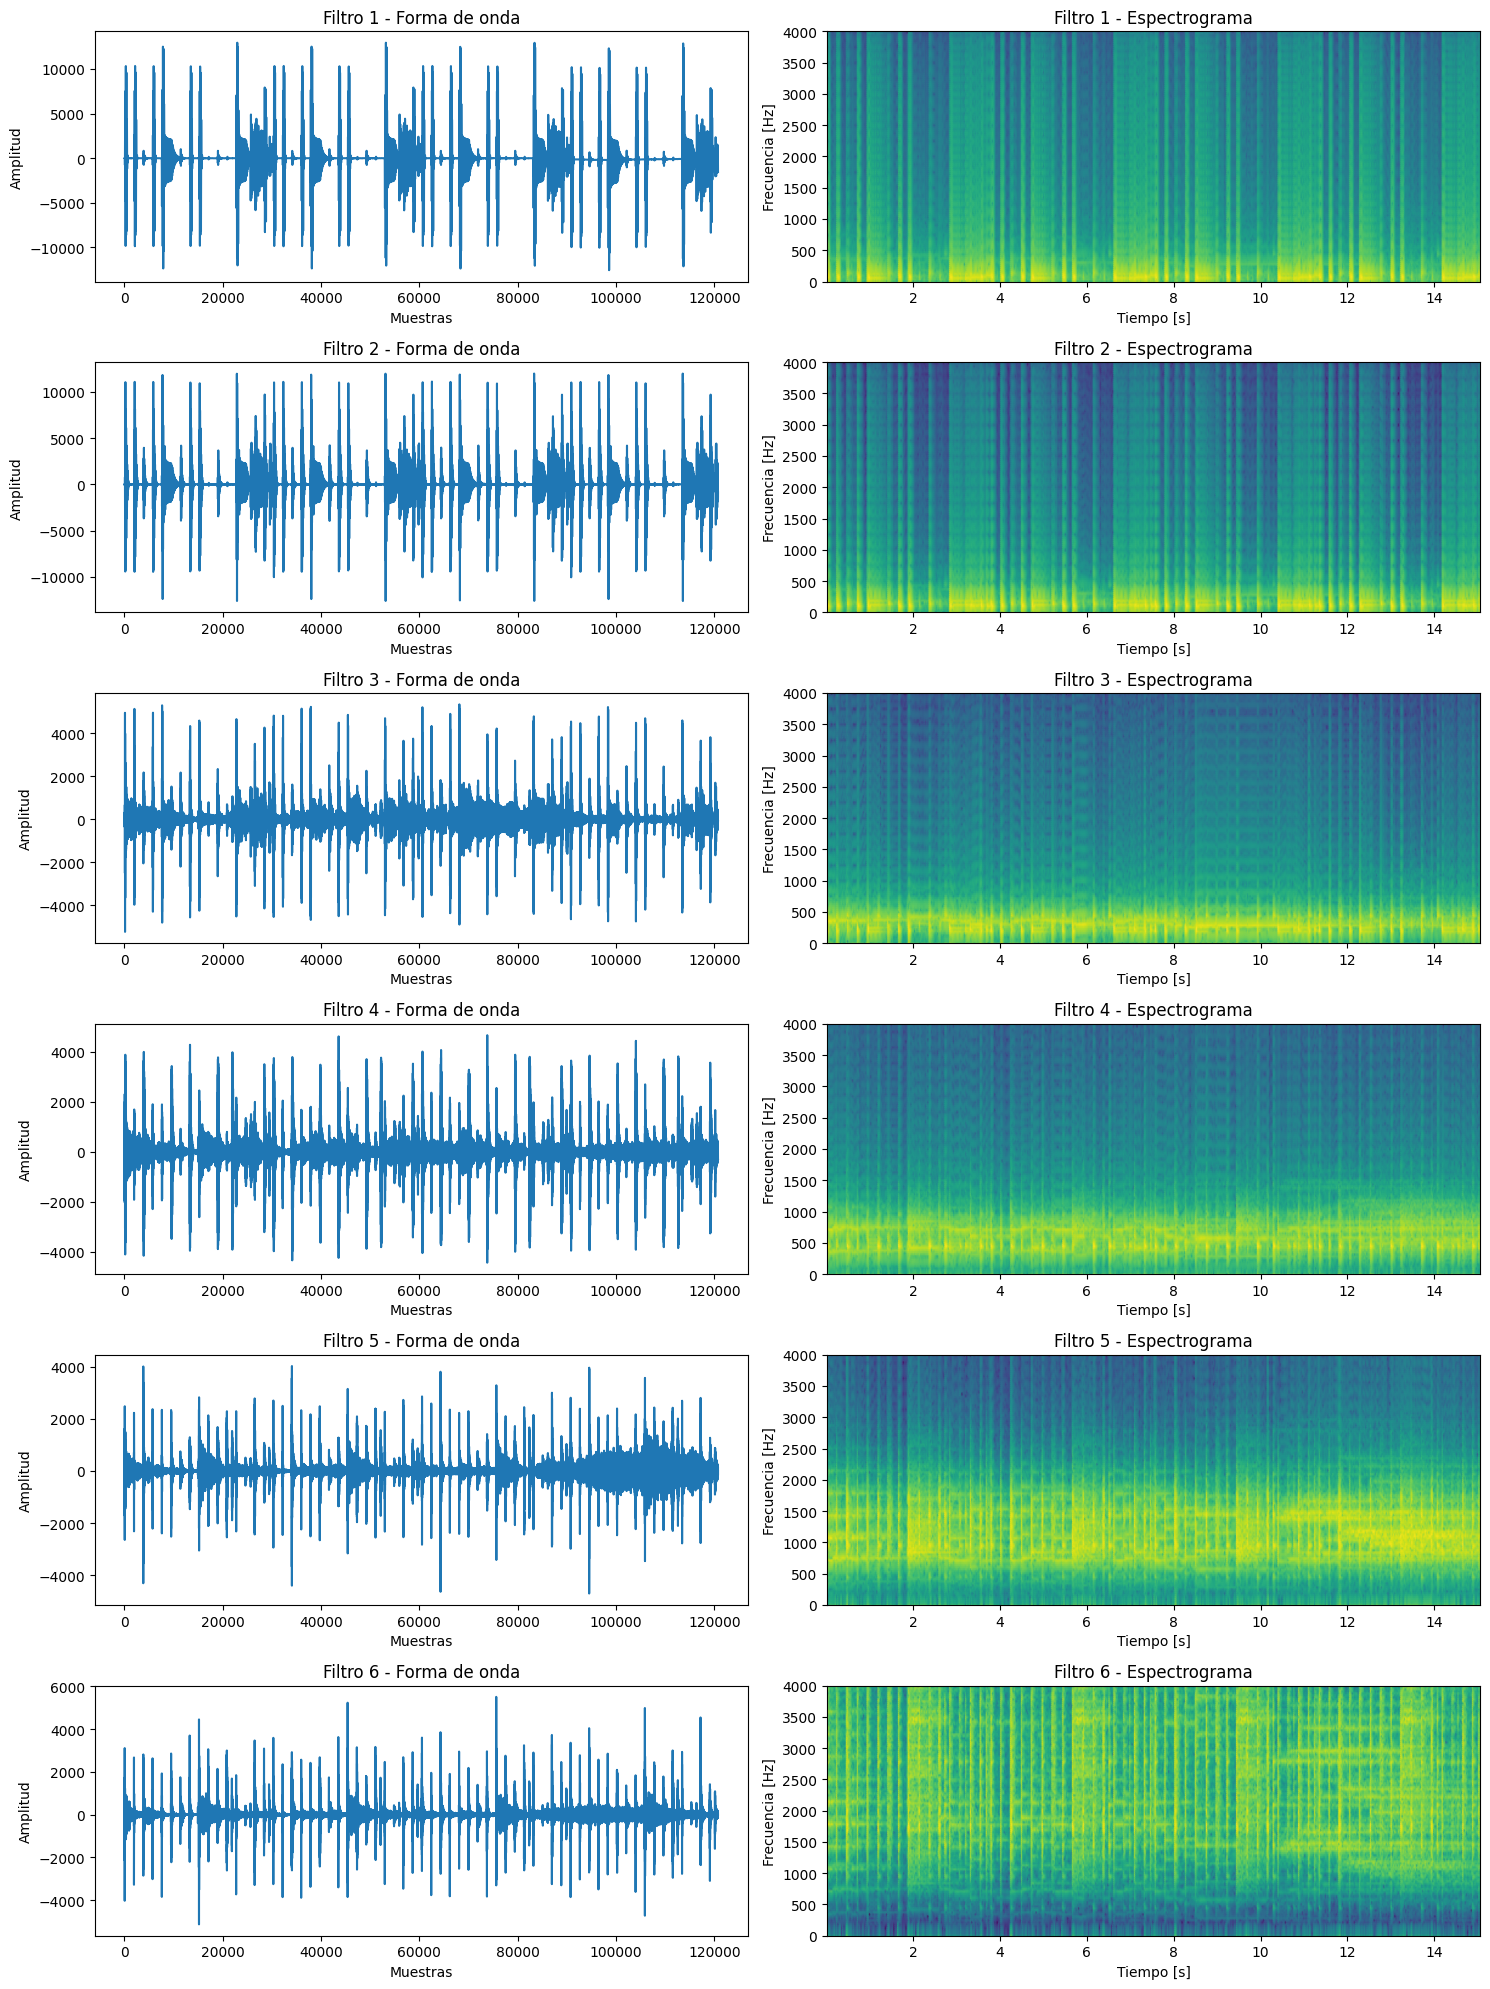

In [18]:
from scipy.signal import butter, lfilter, spectrogram
import numpy as np

def crear_filtros_butterworth(num_filtros, f1, factor, fs, orden=5):
    filtros = []
    nyq = 0.5 * fs
    # Filtro pasa bajos
    alto = f1 / nyq
    b, a = butter(orden, alto, btype='low')
    filtros.append((b,a))
    for i in range(1,num_filtros-1):
        # Filtro pasa banda
        bajo = f1 * (factor ** (i-1)) / nyq
        alto = f1 * (factor ** i) / nyq
        b, a = butter(orden, [bajo, alto], btype='band')
        filtros.append((b, a))
    # Filtro pasa altos
    bajo = f1 * (factor ** (num_filtros-2)) / nyq
    b, a = butter(orden, bajo, btype='high')
    filtros.append((b,a))
    return filtros

def aplicar_filtros(datos, filtros, fs):
    senales_filtradas = []
    for b, a in filtros:
        y = lfilter(b, a, datos)
        senales_filtradas.append(y)
    return senales_filtradas

filtros = crear_filtros_butterworth(6, 100, 2, sr)
senales_filtradas = aplicar_filtros(data, filtros, sr)

fig, axs = plt.subplots(6, 2, figsize=(15, 20))
for i, senal in enumerate(senales_filtradas):
    # Graficar forma de onda
    axs[i, 0].plot(senal)
    axs[i, 0].set_title(f'Filtro {i+1} - Forma de onda')
    axs[i, 0].set_xlabel('Muestras')
    axs[i, 0].set_ylabel('Amplitud')
    
    # Graficar espectrograma
    f, t, Sxx = spectrogram(senal, sr)
    axs[i, 1].pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    axs[i, 1].set_title(f'Filtro {i+1} - Espectrograma')
    axs[i, 1].set_xlabel('Tiempo [s]')
    axs[i, 1].set_ylabel('Frecuencia [Hz]')

plt.tight_layout()
plt.show()


In [21]:
# calculamos la envolvente

def calcular_envolvente(senal):
    envolvente = np.abs(senal)
    envolvente = lfilter([1], [1, -0.9], envolvente)
    return envolvente

envolventes = [calcular_envolvente(senal) for senal in senales_filtradas]



Cada una por separado:
Filtro 1


Filtro 2


Filtro 3


Filtro 4


Filtro 5


Filtro 6


Salida Final


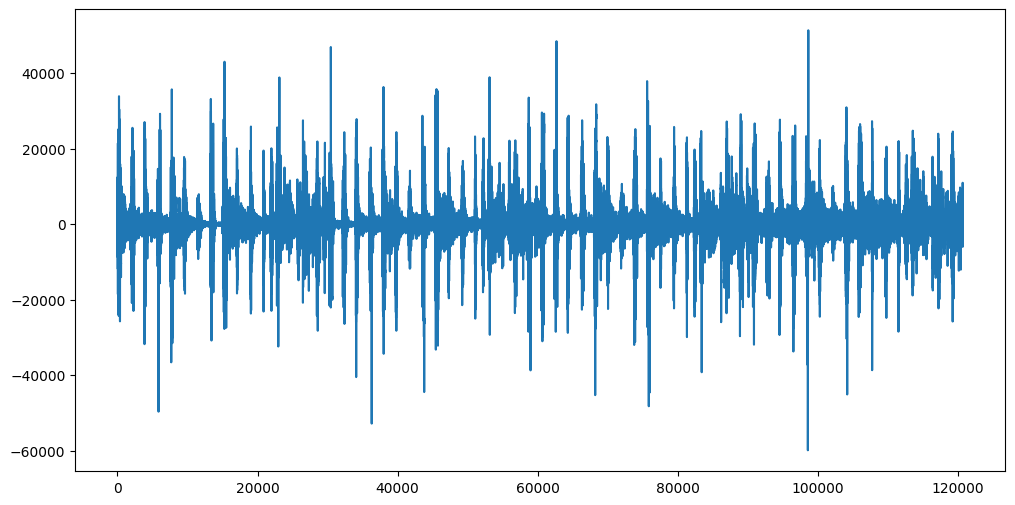

In [25]:
# ruido blanco
ruido_blanco = np.random.randn(len(data))

# filtramos el ruido blanco
ruido_filtrado = [lfilter(b, a, ruido_blanco) for b, a in filtros]

# modulamos la envolvente
senales_moduladas = [senal * envolvente for senal, envolvente in zip(ruido_filtrado, envolventes)]

print("Cada una por separado:")
for i, senal in enumerate(senales_moduladas):
    print(f"Filtro {i+1}")
    display(Audio(senal, rate=sr))

# sumamos las señales moduladas
senal_salida = np.sum(senales_moduladas, axis=0)

# escuchamos la señal de salida
print("Salida Final")
display(Audio(senal_salida, rate=sr))

# graficamos la señal de salida
plt.figure(figsize=(12, 6))
plt.plot(senal_salida)




## Parte 2

En esta parte se explorará el mismo procedimiento que la Parte 1 sobre el audio [_tamy_8k.wav_](./Archivos_P2/tamy_8k.wav), que contiene únicamente voz cantada y guitarra (sin instrumentos "percusivos").

Repita el procedimiento anterior, pero **aumentando el número de bandas a 12**. Para ello puede ser útil separar logarítmicamente las frecuencias de corte por un factor de $1.4$ .

Evaluar perceptualmente los resultados del audio sintetizado y responder:

1. ¿Es posible identificar la melodía de la guitarra y la voz?
1. ¿Se puede identificar cuándo ocurren los ataques de las notas en la guitarra?
1. ¿Se pueden percibir características de los fonemas de la voz?

Comente y justifique **brevemente** todas sus respuestas.

In [ ]:
sr, data = io.wavfile.read(dir_files+'tamy_8k.wav')
if len(data.shape) > 1:
    data = (data[:,0].astype(float) + data[:,1].astype(float))/2

Audio(data=data, rate=sr)

# Ejercicio 2

En este ejercicio se implementa el algoritmo de Karplus y Strong para síntesis de cuerda pulsada [3]. Se sugiere consultar [4] por una descripción detallada.


## Parte 1

Como primer paso se estudia la respuesta al impulso de un filtro peine.


1. Escribir la ecuación en recurrencia de un filtro peine en función del retardo $L$ y la atenuación por muestra $R$ del filtro. Indicar la frecuencia fundamental de la respuesta al impulso en función de los parámetros del filtro y la frecuencia de muestreo ¿Es posible conseguir una respuesta al impulso con frecuencia fundamental arbitraria?
2. Sintetizar las 12 notas de una octava de la *escala igualmente temperada* (en el temperamento igual se divide la octava en 12 intervalos iguales, de modo que las frecuencias de dos notas consecutivas cumplen la relación $f_{n+1} = f_{n} \, 2^{(\frac{1}{12})}$) comenzando en $110~Hz$ ($A2$). Para esto, se sugiere hacer lo siguiente:

     - Calcular el parámetro $L$ del filtro para que la frecuencia fundamental de la respuesta al impulso sea lo más cercana posible a la nota deseada. Utilice una frecuencia de muestreo de $f_s$ = $22050~Hz$).

     - Filtrar un impulso con cada uno de los filtros diseñados.
     - Concatenar la respuesta al impulso de cada filtro para obtener una señal con todas las notas.
    

3. Variar el parámetro $R$ y analizar su efecto mediante un espectrograma.

## Parte 2

Como primer refinamiento del modelo se incluye un filtro pasabajos en el lazo de realimentación.
En [3] se usa un filtro de media móvil de primer orden ($M=2$).


1. ¿Qué característica de la señal de una cuerda pulsada modela este filtro?
1. Calcular la ecuación en recurrencia del filtro peine incluyendo el pasabajos en el lazo de realimentación.
1. Indicar la frecuencia fundamental de la respuesta al impulso en función de los parámetros del filtro peine y la frecuencia de muestreo.
1. Repetir el punto 2 de la parte 1 con el sistema incluyendo el pasabajos.
1. Evaluar auditivamente el resultado de la síntesis al agregar el pasabajos.

## Parte 3

Levantar el archivo de audio [_201a_22k.wav_](./Archivos_P2/201a_22k.wav), que corresponde al sonido de la nota $A2$ ($f_0=110~Hz$) en cuerda pulsada de una guitarra [5].

Escuchar dicho archivo, visualizar la forma de onda y espectrograma de dicha señal. Compararla cualitativamente con la señal sintetizada tanto en percepción auditiva como en las gráficas mencionadas. Discutir en los aspectos de:

- El ataque de la señal
- La atenuación de frecuencias altas
- Armónicos presentes

In [ ]:
sr_guitar, guitar = io.wavfile.read(dir_files+'201a_22k.wav')
Audio(guitar, rate=sr_guitar)

**_Respuesta:_**

## Parte 4

Como segunda etapa de refinamiento del modelo se incluye un filtro pasatodos (con un polo en \(a\) y un cero en \(1/a\)) en serie con el filtro pasabajos.

Su objetivo es crear retardos fraccionarios para producir frecuencias fundamentales arbitrarias.


1. Calcular la ecuación en recurrencia del filtro peine incluyendo el pasabajos y el pasatodos en el lazo de realimentación.
1. Indicar la frecuencia fundamental de la respuesta al impulso en función de los parámetros de los filtros peine y pasatodos, y la frecuencia de muestreo.
1. Repetir el punto 2 de la parte 1 afinando el sistema en la frecuencia exacta de las notas de la escala. En el primer paso además de calcular el parámetro \(L\) del filtro peine hay que calcular el parámetro \(a\) del filtro pasatodos.
1. Calcular experimentalmente el error (en Hz) entre la frecuencia fundamental de cada nota sintetizada y su correspondiente en la escala temperada, con y sin el uso del filtro pasatodos. ¿A qué se debe dicho error?

**Observación:** como la frecuencia fundamental de una nota no varía en el tiempo, es posible obtener una estimación bastante precisa mediante la detección del primer pico de la DFT de la señal completa de la nota.

# Referencias

[1] Scheirer, Eric D, "Tempo and beat analysis of acoustic musical signals", *The Journal of the Acoustical Society of America,* vol. 103, no.1, pp.588 601, 1998.

[2] ethno beat.wav by zagi2 -- https://freesound.org/s/353234/ -- License: Attribution NonCommercial 4.0

[3] Kevin Karplus and Alex Strong, "Digital Synthesis of Plucked String and Drum Timbres", *Computer Music Journal,* vol.7, no.2, pp. 43-55, 1983.

[4] Ken Steiglitz, *Digital Signal Processing Primer: With Applications to Digital Audio and Computer Music,* ch. Comb and String Filters. Prentice Hall, 1996.

[5] 201A.wav by casualdave -- https://freesound.org/s/44729/ -- License: Sampling+
